# Expanding z-score for detecting historical anomalies

This code performs anomaly detection on air quality pollutant data using Z-scores with an expanding window. Outline:
1. Computes the mean and standard deviation of all previous values of the pollutant
2. Calculates a how many standard deviations the current value is from the past mean (z-score)
3. Flags as an anomaly if |z| > thresh (default is 3).

First attempt at anomaly detection. Only finds historical anomalies using mean, does not forecast.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt

def load_data(filepath, chunk=None):
    df = pd.read_csv(filepath, skipinitialspace=True)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Convert all columns (except date) to numeric
    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort by date
    df = df.sort_values(by='date').reset_index(drop=True)

    # Optionally aggregate by week or month
    if chunk in ['week', 'month']:
        df = df.set_index('date')

        if chunk == 'week':
            df = df.resample('W').mean()
        elif chunk == 'month':
            df = df.resample('M').mean()

        df = df.reset_index()

    return df

def rolling_avg_anomalies(df, pollutant, window=7, thresh=3):
    df = df.copy()
    
    # Drop NaNs for the pollutant
    df = df[['date', pollutant]].dropna()

    # Calculate rolling mean and std
    df['rolling_mean'] = df[pollutant].rolling(window=window).mean()
    df['rolling_std'] = df[pollutant].rolling(window=window).std()

    # Z-score based on rolling statistics
    df['z_score'] = (df[pollutant] - df['rolling_mean']) / df['rolling_std']

    # Flag anomalies
    df['anomaly'] = df['z_score'].abs() > thresh

    return df

def expanding_zscore_anomaly(df, pollutant, thresh=3):
    df = df.copy()
    df['z_score'] = np.nan
    df['anomaly'] = 0

    for i in range(2, len(df)):  # start from index 2 to have at least 2 points
        history = df.iloc[:i]
        mean = history[pollutant].mean()
        std = history[pollutant].std()

        if std == 0 or np.isnan(std):
            continue

        z = (df.at[i, pollutant] - mean) / std
        df.at[i, 'z_score'] = z
        if abs(z) > thresh:
            df.at[i, 'anomaly'] = 1

    return df

def plot_anomalies(df, pollutant):
    plt.figure(figsize=(14, 5))
    plt.plot(df['date'], df[pollutant], label='Observed')
    plt.scatter(df[df['anomaly'] == 1]['date'], 
                df[df['anomaly'] == 1][pollutant], 
                color='red', label='Anomaly', zorder=5)
    plt.title(f"{pollutant} - Expanding Window Z-score Anomalies")
    plt.xlabel("Date")
    plt.ylabel(pollutant)
    plt.legend()
    plt.grid(True)
    plt.show()

          date        pm25   z_score
4   2014-02-02  235.142857  3.180074
101 2015-12-13  252.571429  3.892199
103 2015-12-27  252.000000  3.603856
174 2017-05-07  253.714286  3.575601
312 2019-12-29  233.428571  3.192981
314 2020-01-12  240.857143  3.327993
315 2020-01-19  301.000000  5.143274
316 2020-01-26  307.571429  5.129592
317 2020-02-02  282.571429  4.198191


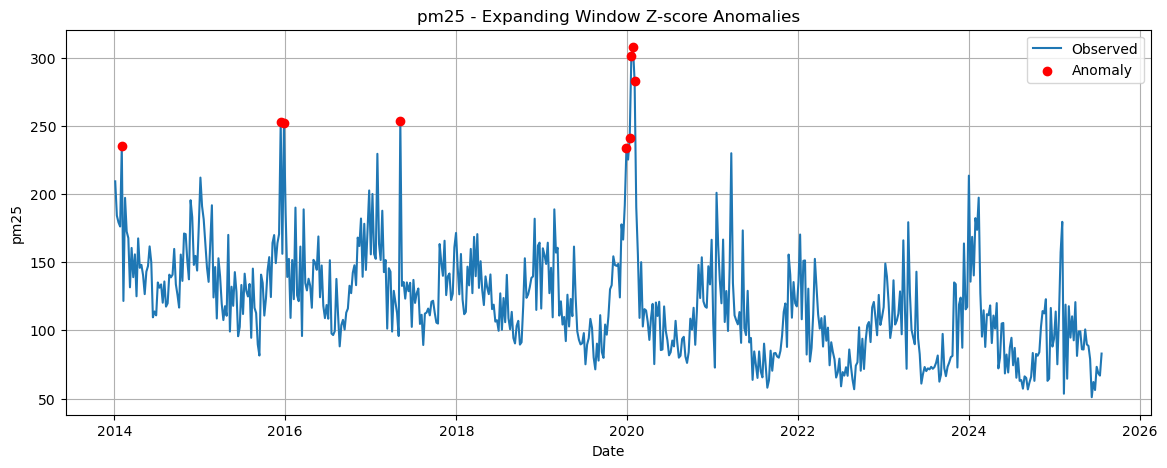

          date        pm10   z_score
5   2014-02-09   89.857143 -3.889703
174 2017-05-07  307.428571  4.500315
221 2018-04-01  258.571429  3.441805
316 2020-01-26  239.857143  3.107113
367 2021-01-17  397.285714  6.783304
376 2021-03-21  342.142857  5.242540
481 2023-03-26  253.000000  3.400464
484 2023-04-16  268.857143  3.698750


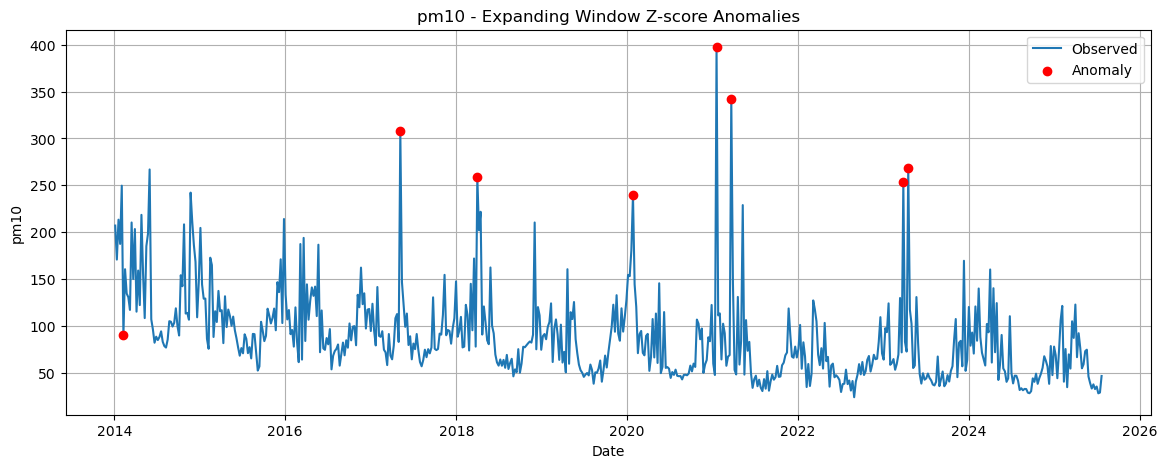

          date        no2   z_score
5   2014-02-09  23.428571 -6.183524
52  2015-01-04  43.500000  3.149509
313 2020-01-05  48.400000  4.104218
315 2020-01-19  47.857143  3.844786


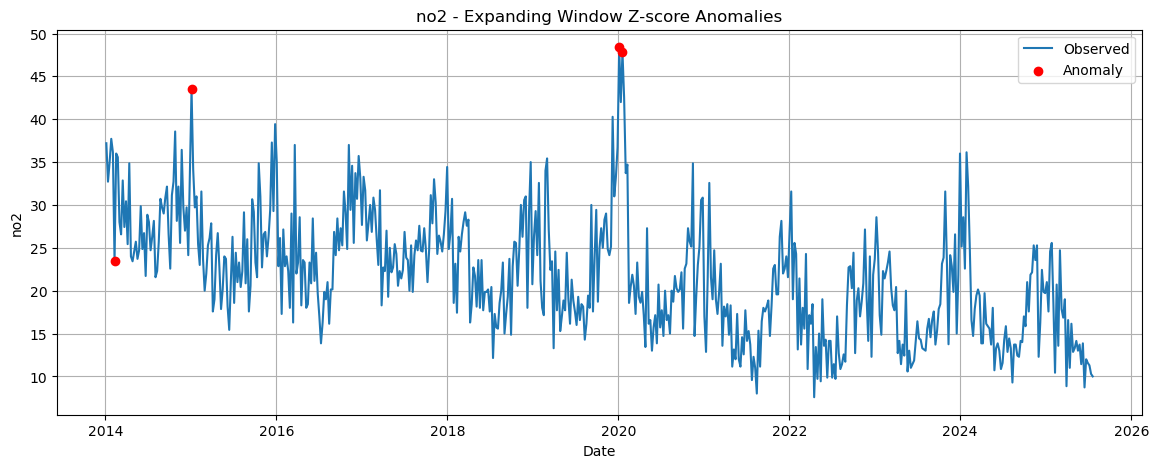

        date        so2  z_score
5 2014-02-09  45.142857 -5.18546


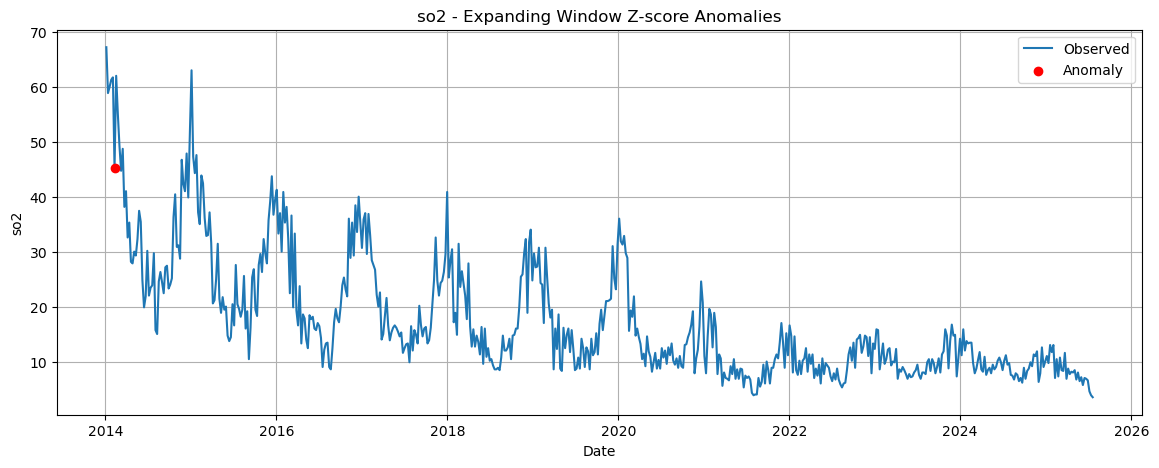

          date         co   z_score
5   2014-02-09  22.428571 -3.030968
313 2020-01-05  46.800000  3.264022


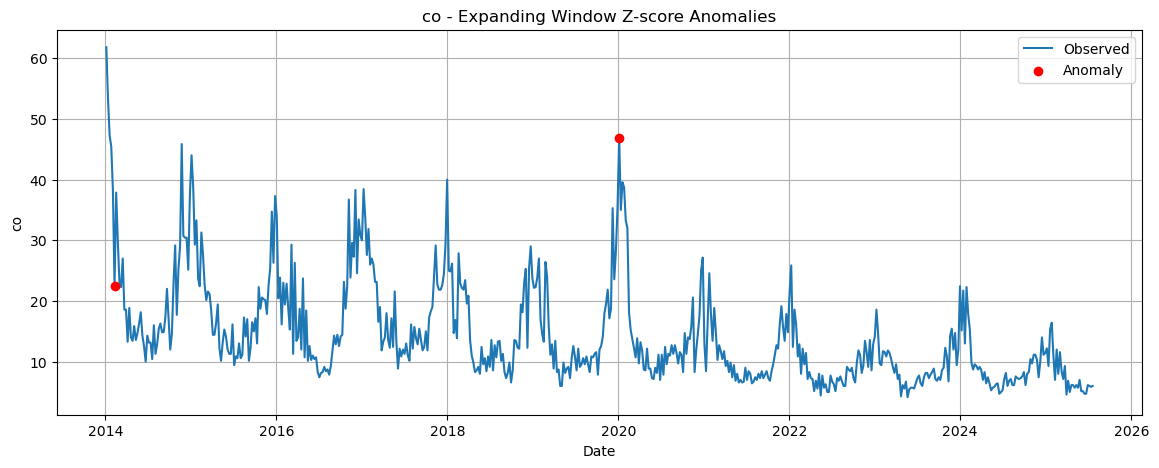

In [2]:
# Choose city and average by day, week, or month
df = load_data("aqicn_data/baotou.csv", chunk="week")
pollutants = ['pm25','pm10','no2','so2','co']

for pollutant in pollutants:
    df_anomalies = expanding_zscore_anomaly(df, pollutant, thresh=3)
    print(df_anomalies[df_anomalies['anomaly'] == 1][['date', pollutant, 'z_score']])
    plot_anomalies(df_anomalies, pollutant)